## Natural Language Processing(NLP)- Text Classification

The goal is to build a Naïve Bayes classification model that is able to predict the class (category) of an unseen document correctly out of 91 classes

In [355]:
# Importing needed libraries
import os
import pandas as pd

# Cleaning and Normalization
import re
import numpy as np
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# EDA
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from collections import defaultdict

# Features Engineering
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelling and Evaluating
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, precision_recall_fscore_support
import pickle 


## 1. Reading data

In [309]:
def read_folders_to_dataframe(parent_dir: str) -> pd.DataFrame:
    data = []
    # loop through each folder in the parent directory and its subdirectories
    for root, _, files in os.walk(parent_dir):
        for file_name in files:
            file_path = os.path.join(root, file_name)
            try:
                with open(file_path, 'r', encoding='utf-8-sig') as f:
                    file_contents = f.read()
            except UnicodeDecodeError:
                with open(file_path, 'r', encoding='latin-1') as f:
                    file_contents = f.read()
            # append the folder name and file contents to the list
            data.append([os.path.basename(root), file_contents])
    # create a DataFrame from the list
    df = pd.DataFrame(data, columns=['folder_name', 'file_contents'])
    return df



In [310]:
data = read_folders_to_dataframe('./test')
print(data.head(10))


  folder_name                                      file_contents
0         tin  \n\nTIN TRADERS' RESPONSE MUTED TO KL FUTURES ...
1         tin  \n\nITC CONTESTS USE OF DOCUMENTS AS COURT EVI...
2         tin  \n\nSPOT TIN EASIER ON EUROPEAN FREE MARKET\n\...
3         tin  \n\nTHAI SMELTER FACES TIN CONCENTRATE SUPPLY ...
4         tin  \n\nTIN COUNCIL ALLOWED APPEAL ON USE OF DOCUM...
5         tin  \n\nSUBROTO SAYS INDONESIA SUPPORTS TIN PACT E...
6         tin  \n\nMALAYSIA TO RESEARCH TIN, WARY ON VEG OILS...
7         tin  \n\nTALKS CONTINUE ON TIN AGREEMENT EXTENSION\...
8         tin  \n\nTHAI TRADE DEFICIT WIDENS IN FIRST QUARTER...
9         tin  \n\nEC MAINLY FOR TIN EXTENSION, NO U.K. STAND...


In [311]:
data = data.drop(index=0).reset_index(drop=True)
print(data.head(10))


  folder_name                                      file_contents
0         tin  \n\nITC CONTESTS USE OF DOCUMENTS AS COURT EVI...
1         tin  \n\nSPOT TIN EASIER ON EUROPEAN FREE MARKET\n\...
2         tin  \n\nTHAI SMELTER FACES TIN CONCENTRATE SUPPLY ...
3         tin  \n\nTIN COUNCIL ALLOWED APPEAL ON USE OF DOCUM...
4         tin  \n\nSUBROTO SAYS INDONESIA SUPPORTS TIN PACT E...
5         tin  \n\nMALAYSIA TO RESEARCH TIN, WARY ON VEG OILS...
6         tin  \n\nTALKS CONTINUE ON TIN AGREEMENT EXTENSION\...
7         tin  \n\nTHAI TRADE DEFICIT WIDENS IN FIRST QUARTER...
8         tin  \n\nEC MAINLY FOR TIN EXTENSION, NO U.K. STAND...
9         tin  \n\nPARIS GROUP PUBLISHING DAILY FRANC TIN PRI...


solve the issuse in index [0]

## Text Preprocessing

* It involves cleaning and transforming raw text data into a format that can be easily understood and analyzed by machine learning models 

### Cleaning Text

* Cleaning text involves several steps to prepare the text data for analysis or machine learning. 

In [312]:
## Removes all punctuation marks from a given text.

def remove_punctuations(text):
    return re.sub(r'[^\w\s]', '', text)



In [313]:
## Removes all stopwords from a given text.

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return " ".join(filtered_tokens)


In [314]:
## Removes all non-ASCII characters from a given text.

def remove_special_chars(text):
    return re.sub(r'[^\x00-\x7f]', r'', text) 

In [315]:
## Removes all HTML tags and newlines from a given text.

def remove_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    clean_text = soup.get_text().replace("\n", " ").strip()
    return clean_text

In [316]:
#Remove specific words from text.
def remove_specific_words(text, words_to_remove): 
    tokens = word_tokenize(text)
    return ' '.join([word for word in tokens if word.lower() not in words_to_remove])


In [317]:
## Cleans a given text by removing HTML tags, punctuation marks, stopwords, and non-ASCII characters.

def clean_text(text):
    text = remove_tags(text)
    text = remove_punctuations(text) 
    text = remove_stopwords(text)
    text = remove_special_chars(text)
    
    words_to_remove = ['in', 'us', 'and' ,'to']
    text = remove_specific_words(text, words_to_remove)
    return text

In [318]:
data["text"] = data["file_contents"].apply(clean_text)
data.head()

,folder_name,file_contents,text
0,tin,\n\nITC CONTESTS USE OF DOCUMENTS AS COURT EVI...,ITC CONTESTS USE OF DOCUMENTS AS COURT EVIDENC...
1,tin,\n\nSPOT TIN EASIER ON EUROPEAN FREE MARKET\n\...,SPOT TIN EASIER ON EUROPEAN FREE MARKET LONDON...
2,tin,\n\nTHAI SMELTER FACES TIN CONCENTRATE SUPPLY ...,THAI SMELTER FACES TIN CONCENTRATE SUPPLY SHOR...
3,tin,\n\nTIN COUNCIL ALLOWED APPEAL ON USE OF DOCUM...,TIN COUNCIL ALLOWED APPEAL ON USE OF DOCUMENTS...
4,tin,\n\nSUBROTO SAYS INDONESIA SUPPORTS TIN PACT E...,SUBROTO SAYS INDONESIA SUPPORTS TIN PACT EXTEN...


### Normalize Text

Normalizing text typically involves converting text to a standard form or representation. 


* Stemmer text : using PorterStemmer



* Lower case text

In [319]:
def stem_text(text):
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return " ".join(stemmed_tokens)

In [320]:
def standardize_text(text):
    return text.lower()


In [321]:
def normalize_text(text):
    text = stem_text(text)
    text = standardize_text(text)
    return text


In [322]:
data["text"] = data["text"].apply(normalize_text)
data.head()

,folder_name,file_contents,text
0,tin,\n\nITC CONTESTS USE OF DOCUMENTS AS COURT EVI...,itc contest use of document as court evid lond...
1,tin,\n\nSPOT TIN EASIER ON EUROPEAN FREE MARKET\n\...,spot tin easier on european free market london...
2,tin,\n\nTHAI SMELTER FACES TIN CONCENTRATE SUPPLY ...,thai smelter face tin concentr suppli shortag ...
3,tin,\n\nTIN COUNCIL ALLOWED APPEAL ON USE OF DOCUM...,tin council allow appeal on use of document lo...
4,tin,\n\nSUBROTO SAYS INDONESIA SUPPORTS TIN PACT E...,subroto say indonesia support tin pact extens ...


In this step I'll perform:

* Word tokenization: using NLTK.


## Text Vectorization



In text vectorization , the goal is to represent the text data numerically in a way that can be used for machine learning. In this case, I have used the TfidfVectorizer from the scikit-learn library to vectorize the preprocessed text data. This involves computing the term frequency-inverse document frequency (tf-idf) score for each word in the text, which represents how important each word is in the context of the entire corpus. 

After vectorizing the text data, I have concatenated the resulting sparse matrix with additional features including the document length and presence of certain class names in each document. This was done using the numpy library. The features were selected based on the exploratory data analysis (EDA) performed on the dataset. The EDA involved analyzing the distribution of classes, identifying the most common words in each class, and calculating the average text length. Based on the insights gained from the EDA, the features selected were document length and Average Frequency of numbers in each Class.
Overall, the libraries used for text vectorization in this case include scikit-learn, matplotlib.pyplot and numpy.

## Extract the TD-IDF Vector for each document.

In this step I'll perform:

* Word tokenization: using NLTK.
* TF-IDF Matrix: using the TfidfVectorizer from sklearn.

### Word tokenization

In [323]:
# Word tokenization
data['tokens'] = data['text'].apply(lambda x: nltk.word_tokenize(x.lower()))
data.head() 

,folder_name,file_contents,text,tokens
0,tin,\n\nITC CONTESTS USE OF DOCUMENTS AS COURT EVI...,itc contest use of document as court evid lond...,"[itc, contest, use, of, document, as, court, e..."
1,tin,\n\nSPOT TIN EASIER ON EUROPEAN FREE MARKET\n\...,spot tin easier on european free market london...,"[spot, tin, easier, on, european, free, market..."
2,tin,\n\nTHAI SMELTER FACES TIN CONCENTRATE SUPPLY ...,thai smelter face tin concentr suppli shortag ...,"[thai, smelter, face, tin, concentr, suppli, s..."
3,tin,\n\nTIN COUNCIL ALLOWED APPEAL ON USE OF DOCUM...,tin council allow appeal on use of document lo...,"[tin, council, allow, appeal, on, use, of, doc..."
4,tin,\n\nSUBROTO SAYS INDONESIA SUPPORTS TIN PACT E...,subroto say indonesia support tin pact extens ...,"[subroto, say, indonesia, support, tin, pact, ..."


In [324]:
# Define the TfidfVectorizer with desired settings
tfidf = TfidfVectorizer(stop_words='english', lowercase=True, min_df=5, max_df=0.8)

# Fit the TfidfVectorizer on the tokenized data
tfidf.fit(data['tokens'].apply(lambda x: ' '.join(x)))

# Transform the tokenized data into TF-IDF vectors
tfidf_vectors = tfidf.transform(data['tokens'].apply(lambda x: ' '.join(x)))

In [325]:
tfidf_vectors

<4023x5425 sparse matrix of type '<class 'numpy.float64'>'
	with 219233 stored elements in Compressed Sparse Row format>

### Vocabulary set extraction.

In [326]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

documents = data['text'].tolist() 

# Create a CountVectorizer to convert text data into a bag-of-words representation
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(documents)

# Get the vocabulary set
vocabulary_set = set(vectorizer.get_feature_names_out())


print("The first 10 words in the Vocabulary Set:", list(vocabulary_set)[:10])

print("Number of words in the Vocabulary Set:", len(vocabulary_set))

The first 10 words in the Vocabulary Set: ['1418', '1000franc', 'zolling', '4028', '4018', '2296', '7182', '8598198', 'chronar', '7290']
Number of words in the Vocabulary Set: 19346


## Exploaraity Data Analysis - EDA.

 this step include :
    
    
* Plot the distribution of classes using bar plot.
    
    
* Average Text Length using bar plot.
    
    
* Most Common words in each class and its frequency using Word Cloud.

### Plot the distribution of classes


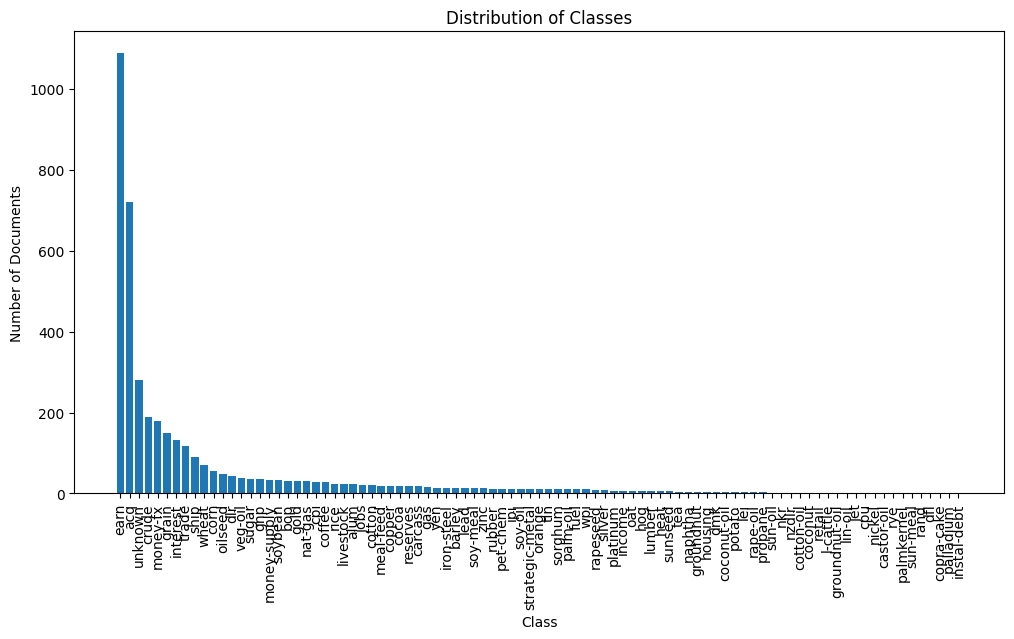

In [327]:
import matplotlib.pyplot as plt
# Count the number of documents in each class
class_counts = data['folder_name'].value_counts()

# Plot the distribution of classes
plt.figure(figsize=(12,6))
plt.bar(class_counts.index, class_counts.values)
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of Documents')
plt.title('Distribution of Classes')
plt.show()

1- The distribution of classes is imbalanced. 



2- "earn" class include largest number of doc


### Average Text Length

In [328]:
def sort_dataframe_by_text_length(data):
    # Add a new column with the length of the 'text' column
    data['text_length'] = data['text'].str.len()

    # Sort the DataFrame based on the length of the 'text' column within each class
    df_sorted = data.sort_values(by=['folder_name', 'text_length'], ascending=[True, False])

    return df_sorted



In [329]:
data = sort_dataframe_by_text_length(data)
data


,folder_name,file_contents,text,tokens,text_length
3478,acq,\n\nENERGY/U.S. PETROCHEMICAL INDUSTRY\n\n<AUT...,energyu petrochem industri by juli vorman reut...,"[energyu, petrochem, industri, by, juli, vorma...",3499
3374,acq,\n\nCOMPUTER ASSOC. <CA> BOLSTERS HAND AGAINST...,comput assoc bolster hand against ibm by lawre...,"[comput, assoc, bolster, hand, against, ibm, b...",3284
3329,acq,\n\nNEW LEADER COMING TO U.S. SEC IN CHALLENGI...,new leader come sec challeng era by irwin arie...,"[new, leader, come, sec, challeng, era, by, ir...",3276
3311,acq,\n\nSAN MIGUEL DEAL HIT BY MORE LAWSUITS\n\n ...,san miguel deal hit by more lawsuit manila apr...,"[san, miguel, deal, hit, by, more, lawsuit, ma...",3025
3584,acq,\n\nBURLINGTON <BUR> HEARING TO CONTINUE TOMOR...,burlington hear continu tomorrow greensboro nc...,"[burlington, hear, continu, tomorrow, greensbo...",2757
...,...,...,...,...,...
3003,zinc,\n\nTHAI ZINC EXPORTS FALL IN MARCH\n\n BAN...,thai zinc export fall march bangkok april 8 th...,"[thai, zinc, export, fall, march, bangkok, apr...",450
2997,zinc,\n\nU.S. MINERALS <USMX.O> COMMISSIONS NEW GOL...,miner commiss new gold mine denver june 29 min...,"[miner, commiss, new, gold, mine, denver, june...",431
3001,zinc,\n\nAMAX ZINC CO RAISES DYECAST ALLOY PRICES\n...,amax zinc co rais dyecast alloy price greenwic...,"[amax, zinc, co, rais, dyecast, alloy, price, ...",240
3007,zinc,\n\nMETAL BULLETIN ZINC PRODUCER PRICE\n\n ...,metal bulletin zinc produc price london april ...,"[metal, bulletin, zinc, produc, price, london,...",175


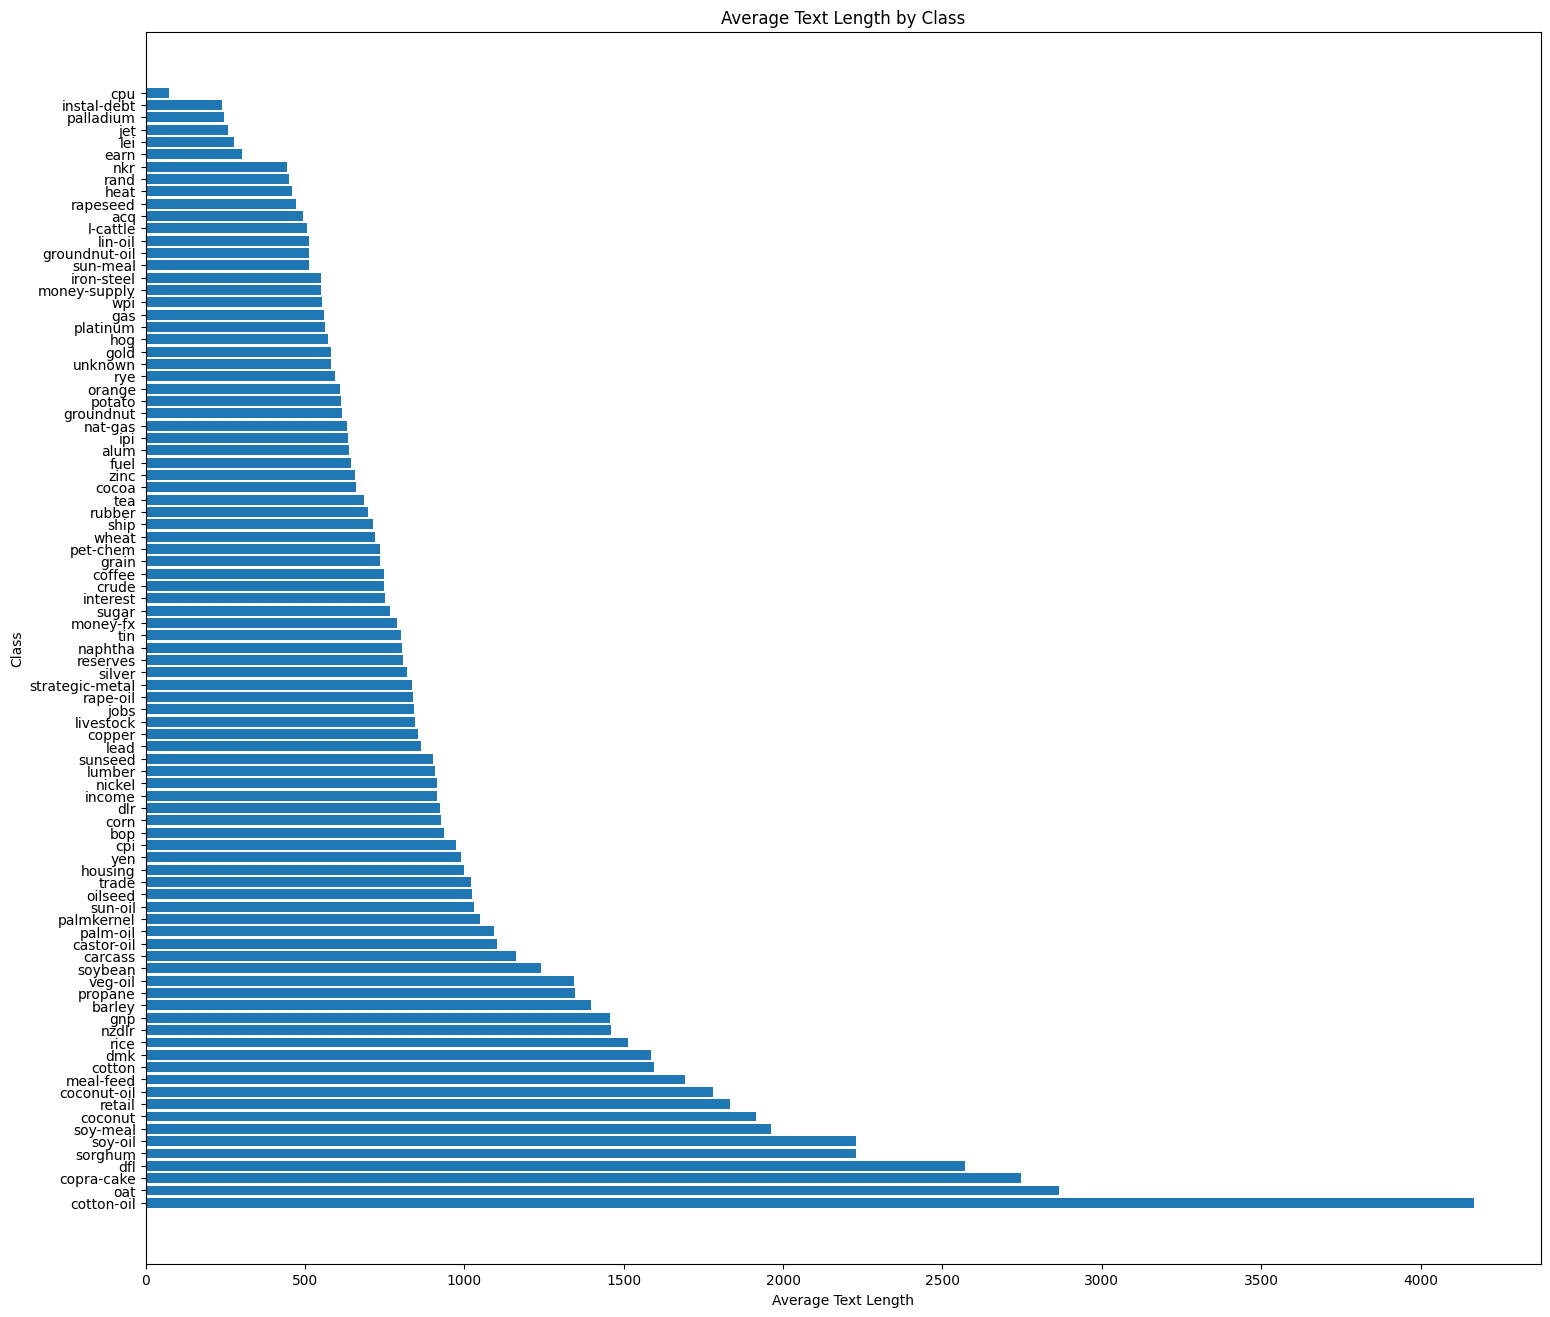

In [330]:
avg_text_length_by_class = data.groupby('folder_name')['text_length'].mean().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(18, 16))
ax.barh(avg_text_length_by_class.index, avg_text_length_by_class.values)
ax.set_xlabel('Average Text Length')
ax.set_ylabel('Class')
ax.set_title('Average Text Length by Class')
plt.show()

* The length of the text gives indication of its class.

## Most Common words in each class and its frequency


In [331]:
def most_frequent_word(text):
  
    words = str(text).split()
    word_counts = Counter(words)
    most_common_word, frequency = word_counts.most_common(1)[0]
    return most_common_word, frequency

def find_most_common_word(data):

    # Apply the most_frequent_word function to each group of the DataFrame
    most_common_words = data.groupby('folder_name')['text'].apply(most_frequent_word).apply(pd.Series)
    most_common_words.columns = ['most_common_word', 'frequency']

    # Reset the index to convert the 'folder_name' group into a column
    most_common_words = most_common_words.reset_index()

    return most_common_words

In [332]:
most_common_words = find_most_common_word(data)

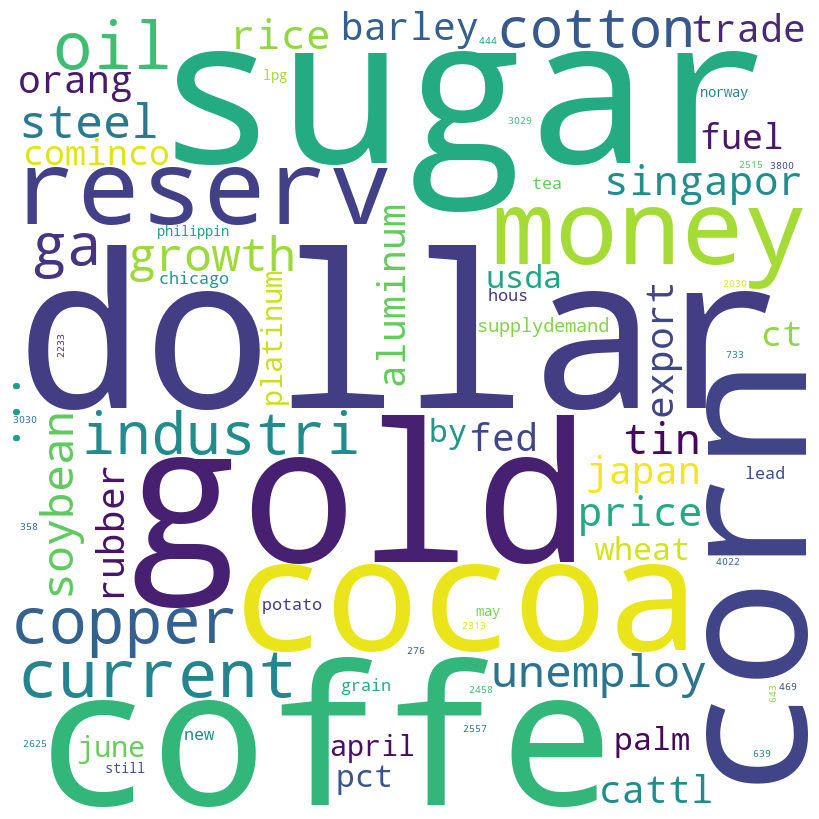

In [333]:
# Convert the dataframe to a dictionary
word_freq_dict = dict(zip(most_common_words['most_common_word'], most_common_words['frequency']))

# Create a WordCloud object with desired settings
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(word_freq_dict)

# Plot the word cloud
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
# Show the plot
plt.show()  

In [334]:
most_frequent = most_common_words[most_common_words["frequency"]>5]
most_frequent[most_frequent["folder_name"] == most_frequent["most_common_word"]]

,folder_name,most_common_word,frequency
2,barley,barley,7
6,cocoa,cocoa,17
10,copper,copper,11
12,corn,corn,18
13,cotton,cotton,10
22,fuel,fuel,6
25,gold,gold,20
68,rice,rice,8
69,rubber,rubber,7
76,soybean,soybean,10


In [335]:
# most 10 common words
most_common_terms = most_common_words.sort_values('frequency', ascending=False).head(10)['most_common_word'].tolist()
print(most_common_terms)

['dollar', 'sugar', 'gold', 'coffe', 'corn', 'cocoa', 'money', 'reserv', 'current', 'oil']


In [336]:
folder_names = set(data['folder_name'].unique())
non_class_freq_term = []

for term in most_common_terms:
    if term not in folder_names:
        non_class_freq_term.append(term)
non_class_freq_term

['dollar', 'coffe', 'money', 'reserv', 'current', 'oil']

## From this substep we conclude that:

1. We have different types of documents: Some of the related to food and Finance. There are also lots of numbers that we need to study their source 
2. Many common words are the same as the class names: We'll consider this point as a feature.
3. There are some terms that are so frequent even tho they're not class names: They're in the non_class_freq_term. I'll add them as features.

## Topic Related terms

Study the frequencies of terms related to these categories: economy, food and technology.

In [337]:
# Define the categories and the corresponding keywords
CATEGORIES= {
    'Finance': ['dollar', 'reserv', 'current', 'inflation', 'economy', 'finance' , 'financial', 'investment', 'market', 'money', 'stock', 'trade', 'Bitcoin', 'Tesla', 'Apple', 'Amazon', 'JP Morgan'],
    'food': ['coffe', 'oil','food', 'eat', 'drink', 'restaurant', 'menu', 'taste', 'cuisine', 'chef'],
}

In [338]:
# Define a function to count the frequency of keywords for each category
def count_keywords(text, keywords):
    count = 0
    for word in keywords:
        escaped_word = re.escape(word)
        count += len(re.findall(rf"\b{escaped_word}\b", text.lower()))
    return count


In [339]:
# Add columns for the frequency of keywords for each category
for category in CATEGORIES:
    data[category] = data['text'].apply(lambda x: count_keywords(x, CATEGORIES[category]))

mean_freq = []
# Calculate the summary statistics for each category
for category in CATEGORIES:
    print(f"Category: {category}")
    print(f"Total number of keywords: {data[category].sum()}")
    print(f"Mean frequency of keywords: {data[category].mean()}")
    mean_freq.append(data[category].mean())
    print()

Category: Finance
Total number of keywords: 7807
Mean frequency of keywords: 1.940591598309719

Category: food
Total number of keywords: 2037
Mean frequency of keywords: 0.506338553318419



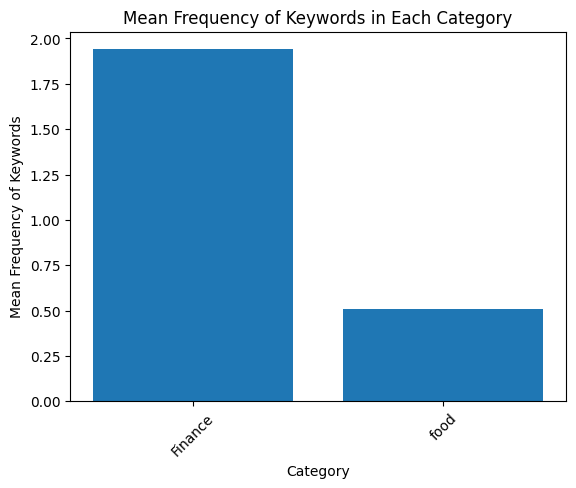

In [340]:
# Plot the mean frequency of keywords for each category
plt.bar(CATEGORIES.keys(), mean_freq)
plt.xticks(rotation=45)
plt.xlabel('Category')
plt.ylabel('Mean Frequency of Keywords')
plt.title('Mean Frequency of Keywords in Each Category')
plt.show()

From the plot we conculde that most documents are related to Finance or talks about Food. 
I'll add all of the topics as features.



### Average Frequency of numbers in each Class.

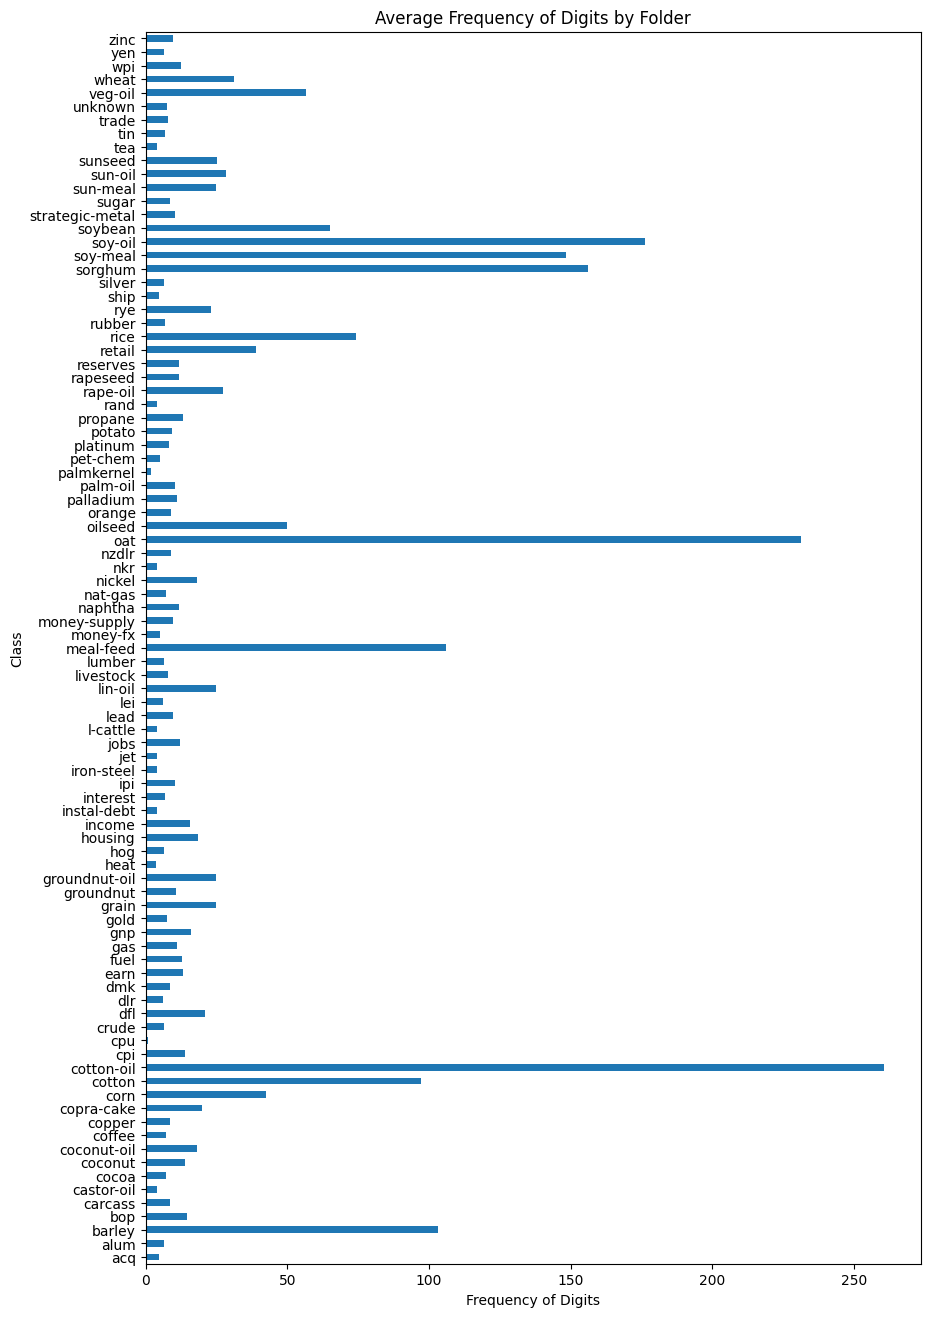

In [341]:
number_pattern = r'\d+(\.\d+)?'

def count_numbers(text):
    return len(re.findall(number_pattern, text))

# Group the data by folder_name and calculate the mean frequency of numbers for each group
freq_by_folder = data.groupby('folder_name')['text'].apply(lambda x: x.apply(count_numbers).mean())

# Plot the results in a horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 16))
freq_by_folder.plot(kind='barh', ax=ax)
ax.set_title('Average Frequency of Digits by Folder')
ax.set_xlabel('Frequency of Digits')
ax.set_ylabel('Class')
plt.show()

The number of digits differ between classes.

### Features Generation and Selection


The features I will add are:

1. Document Length.
2. Prescence of class name in the document.
3. Prescence of topic related words.
3. Frequency of digits in the document.


In [342]:
# Add document length as a feature
# data['doc_length'] = data['text_length']

# Add frequency of digits as a feature
data['digit_freq'] = data['text'].apply(count_numbers) 

# Add frequency of terms from each category as features
for category in CATEGORIES:
    data[f"{category}_freq"] = data[category]

# Add presence of class name in a document as a feature
class_names = set(data['folder_name'].unique())

for class_name in class_names:
    data[class_name] = data['text'].apply(lambda x: int(class_name in x.lower()))

feature_cols = ['doc_length' , 'digit_freq'] + [f"{category}_freq" for category in CATEGORIES] + list(class_names)


In [345]:
data.columns

Index(['Class', 'file_contents', 'text', 'tokens', 'text_length', 'Finance',
       'food', 'digit_freq', 'Finance_freq', 'food_freq',
       ...
       'iron-steel', 'sun-oil', 'heat', 'lei', 'rand', 'nzdlr', 'lin-oil',
       'naphtha', 'nickel', 'ship'],
      dtype='object', length=101)

In [346]:
data = data.rename(columns={'folder_name': 'Class'})
data.drop(columns=["file_contents", "tokens"], inplace=True)


In [350]:
# Convert the sparse matrix to a dense matrix
tfidf_dense = tfidf_vectors.toarray()

# Concatenate the dense matrix with the new features
X = np.concatenate([tfidf_dense, data[['text_length', 'digit_freq'] + [f"{category}_freq" for category in CATEGORIES] + list(class_names)]], axis=1)

print(X)
print(X.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
(4023, 5520)


## Machine Learning Algorithms



I have used three machine learning algorithms, which are: Random Forest, AdaBoost, and Logistic Regression. 



1. **Random Forest** is an ensemble learning method that combines multiple decision trees to improve the overall performance of the model. It works by building a large number of decision trees on random subsets of the training data and then averaging their predictions to obtain the final output. This approach helps to reduce overfitting and improve the accuracy of the model. 
2. **AdaBoost** is also an ensemble learning method that combines multiple weak classifiers to build a strong classifier. It works by assigning weights to each data point and iteratively training weak classifiers on the data with higher weights. In each iteration, the weights of the misclassified data points are increased to give more emphasis on these points in the next iteration. The final output is obtained by combining the predictions of all weak classifiers, weighted by their accuracy. 
3. **Logistic Regression** It works by using a mathematical function called the logistic function to transform input data into a probability score between 0 and 1, which can then be used to make predictions. The logistic regression model estimates the relationship between the input variables and the outcome variable, and then uses this relationship to predict the probability of a positive outcome.

## Training Models



In this step I'll train models on 85% of the data and test on the remaining 15%. 
The models I'll train on are:

* **Random Forest**.
* **AdaBoost**.
* **Logistic Regression**.

### Splitting the data to 85% training and 15% testing.


In [351]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, data['Class'], test_size=0.15, random_state=42)

### Train Random Forest

Hyperparameters:

* n_estimators = 100: the number of trees in the forest
* max_depth = 50: the maximum depth of the trees
* random_state = 42: for reproducibility of results

In [352]:
# Train a Random Forest model on 85% of the data
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Evaluate Random Forest

In [353]:
# Make predictions on the test set
rf_pred = rf_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, rf_pred, zero_division=1))

              precision    recall  f1-score   support

         acq       0.64      0.94      0.76       126
        alum       1.00      0.00      0.00         3
      barley       1.00      0.00      0.00         2
         bop       1.00      0.00      0.00         2
     carcass       1.00      0.00      0.00         3
       cocoa       1.00      0.00      0.00         7
      coffee       1.00      0.00      0.00         3
      copper       1.00      0.00      0.00         4
        corn       0.75      0.33      0.46         9
      cotton       1.00      0.00      0.00         3
  cotton-oil       1.00      0.00      0.00         1
         cpi       1.00      0.00      0.00         3
       crude       0.70      0.78      0.74        27
         dlr       1.00      0.00      0.00         8
        earn       0.73      0.97      0.83       148
        fuel       1.00      0.00      0.00         2
         gas       1.00      0.50      0.67         4
         gnp       1.00    

### Train AdaBoost

In [356]:
# Train an AdaBoost model on 85% of the data
ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_model.fit(X_train, y_train)


AdaBoostClassifier(n_estimators=100, random_state=42)

### Evaluate AdaBoost


In [357]:
# Make predictions on the test set
ada_pred = ada_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, ada_pred, zero_division=1))

              precision    recall  f1-score   support

         acq       0.91      0.55      0.68       126
        alum       1.00      0.00      0.00         3
      barley       1.00      0.00      0.00         2
         bop       1.00      0.00      0.00         2
     carcass       1.00      0.00      0.00         3
       cocoa       1.00      0.00      0.00         7
      coffee       1.00      0.00      0.00         3
      copper       1.00      0.00      0.00         4
        corn       1.00      0.00      0.00         9
      cotton       1.00      0.00      0.00         3
  cotton-oil       1.00      0.00      0.00         1
         cpi       1.00      0.00      0.00         3
       crude       1.00      0.00      0.00        27
         dlr       1.00      0.00      0.00         8
        earn       0.28      0.98      0.43       148
        fuel       1.00      0.00      0.00         2
         gas       1.00      0.00      0.00         4
         gnp       1.00    

### Train Logistic Regression


In [358]:
# Train a logistic regression model on the training data
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)

/Users/mqbwq/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

### Evaluate Logistic Regression 

In [359]:
# Evaluate the model on the testing data
lr_pred = lr_model.predict(X_test)

# Print the classification report 
print(classification_report(y_test, lr_pred, zero_division=1))

              precision    recall  f1-score   support

         acq       0.35      0.64      0.46       126
        alum       1.00      0.00      0.00         3
      barley       1.00      0.00      0.00         2
         bop       1.00      0.00      0.00         2
     carcass       1.00      0.00      0.00         3
       cocoa       1.00      0.00      0.00         7
      coffee       1.00      0.00      0.00         3
      copper       1.00      0.00      0.00         4
        corn       1.00      0.00      0.00         9
      cotton       1.00      0.00      0.00         3
  cotton-oil       1.00      0.00      0.00         1
         cpi       1.00      0.00      0.00         3
       crude       1.00      0.00      0.00        27
         dlr       1.00      0.00      0.00         8
        earn       0.40      0.98      0.57       148
        fuel       1.00      0.00      0.00         2
         gas       1.00      0.00      0.00         4
         gnp       1.00    

## Model Evaluation

## Compare Results of the Three models

In [360]:
# Compute accuracy for each model
rf_acc = accuracy_score(y_test, rf_pred)
ada_acc = accuracy_score(y_test, ada_pred)
lr_acc = accuracy_score(y_test, lr_pred)

# Compute precision, recall, and F1-score for each model
rf_p, rf_r, rf_f1, _ = precision_recall_fscore_support(y_test, rf_pred, average='weighted', zero_division=1)
ada_p, ada_r, ada_f1, _ = precision_recall_fscore_support(y_test, ada_pred, average='weighted', zero_division=1)
lr_p, lr_r, lr_f1, _ = precision_recall_fscore_support(y_test, lr_pred, average='weighted', zero_division=1)

# Print the results
print("Random Forest: Accuracy = {:.3f}, Precision = {:.3f}, Recall = {:.3f}, F1-score = {:.3f}".format(rf_acc, rf_p, rf_r, rf_f1))
print("AdaBoost: Accuracy = {:.3f}, Precision = {:.3f}, Recall = {:.3f}, F1-score = {:.3f}".format(ada_acc, ada_p, ada_r, ada_f1))
print("Logistic Regression: Accuracy = {:.3f}, Precision = {:.3f}, Recall = {:.3f}, F1-score = {:.3f}".format(lr_acc, lr_p, lr_r, lr_f1))

# Compute evaluation metrics for each model
rf_metrics = [rf_acc, rf_p, rf_r, rf_f1]
ada_metrics = [ada_acc, ada_p, ada_r, ada_f1]
lr_metrics = [lr_acc, lr_p, lr_r, lr_f1]



Random Forest: Accuracy = 0.603, Precision = 0.673, Recall = 0.603, F1-score = 0.530
AdaBoost: Accuracy = 0.354, Precision = 0.803, Recall = 0.354, F1-score = 0.248
Logistic Regression: Accuracy = 0.379, Precision = 0.682, Recall = 0.379, F1-score = 0.242
